In [32]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import sklearn
from sklearn.linear_model import LinearRegression 

In [33]:
traindata = pd.read_csv('data/train.csv')
testdata = pd.read_csv('data/test.csv')
print ("Train data shape:", traindata.shape)
print ("Test data shape:", testdata.shape)

Train data shape: (1460, 81)
Test data shape: (1459, 80)


In [34]:
traindata.head(4)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000


* SalePrice - 以美元为单位的物业销售价格 这是你试图预测的目标变量
* MSSubClass - 建筑类
* MSZoning - 一般的分区划分
* LotFrontage - 街道的线性脚与物业相连
* LotArea - 以平方英尺为单位的土地面积
* Street - 进入道路的类型
* Alley - 胡同入口的类型
* LotShape - 属性的一般形状
* LandContour - 酒店的平坦度
* Utilities - 可用的实用程序类型
* LotConfig - 批量配置

更多可看官方提供的英文版或我自己翻译了一下放在`info.txt`

## 查看目标函数与理解相关业务

In [35]:
traindata.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

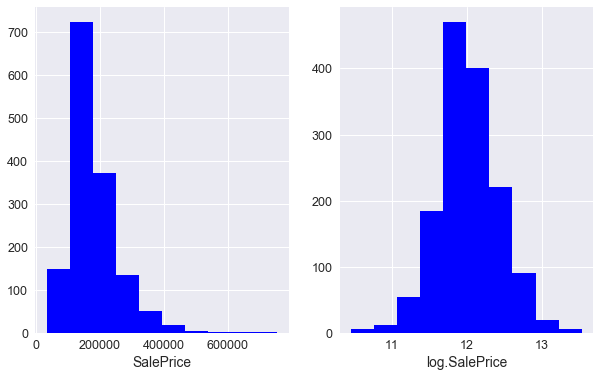

In [36]:
plt.rcParams['figure.figsize'] = (10, 6) #设置图像大小
plt.figure()
plt.subplot(1,2,1)
plt.hist(traindata.SalePrice, color='blue')
plt.xlabel('SalePrice')
plt.subplot(1,2,2)
plt.hist(np.log(traindata.SalePrice), color='blue')
plt.xlabel('log.SalePrice')
plt.show()

## 特征工程
把数据分两类，数字特征与非数字特征

## 处理数字特征
* select_dtypes()方法将返回匹配指定数据类型的列的子集
* DataFrame.corr()方法显示列之间的相关性（或关系）

In [37]:
# 选出只有整数和浮点数的columns
num_trainData = traindata.select_dtypes(include=[np.number])

In [38]:
traindata_corr = num_trainData.corr()['SalePrice'][:-1]

print (traindata_corr[abs(traindata_corr) > 0].sort_values(ascending=False)[:5], '\n')
print (traindata_corr[abs(traindata_corr) > 0].sort_values(ascending=False)[-5:],'\n')

OverallQual    0.790982
GrLivArea      0.708624
GarageCars     0.640409
GarageArea     0.623431
TotalBsmtSF    0.613581
Name: SalePrice, dtype: float64 

YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64 



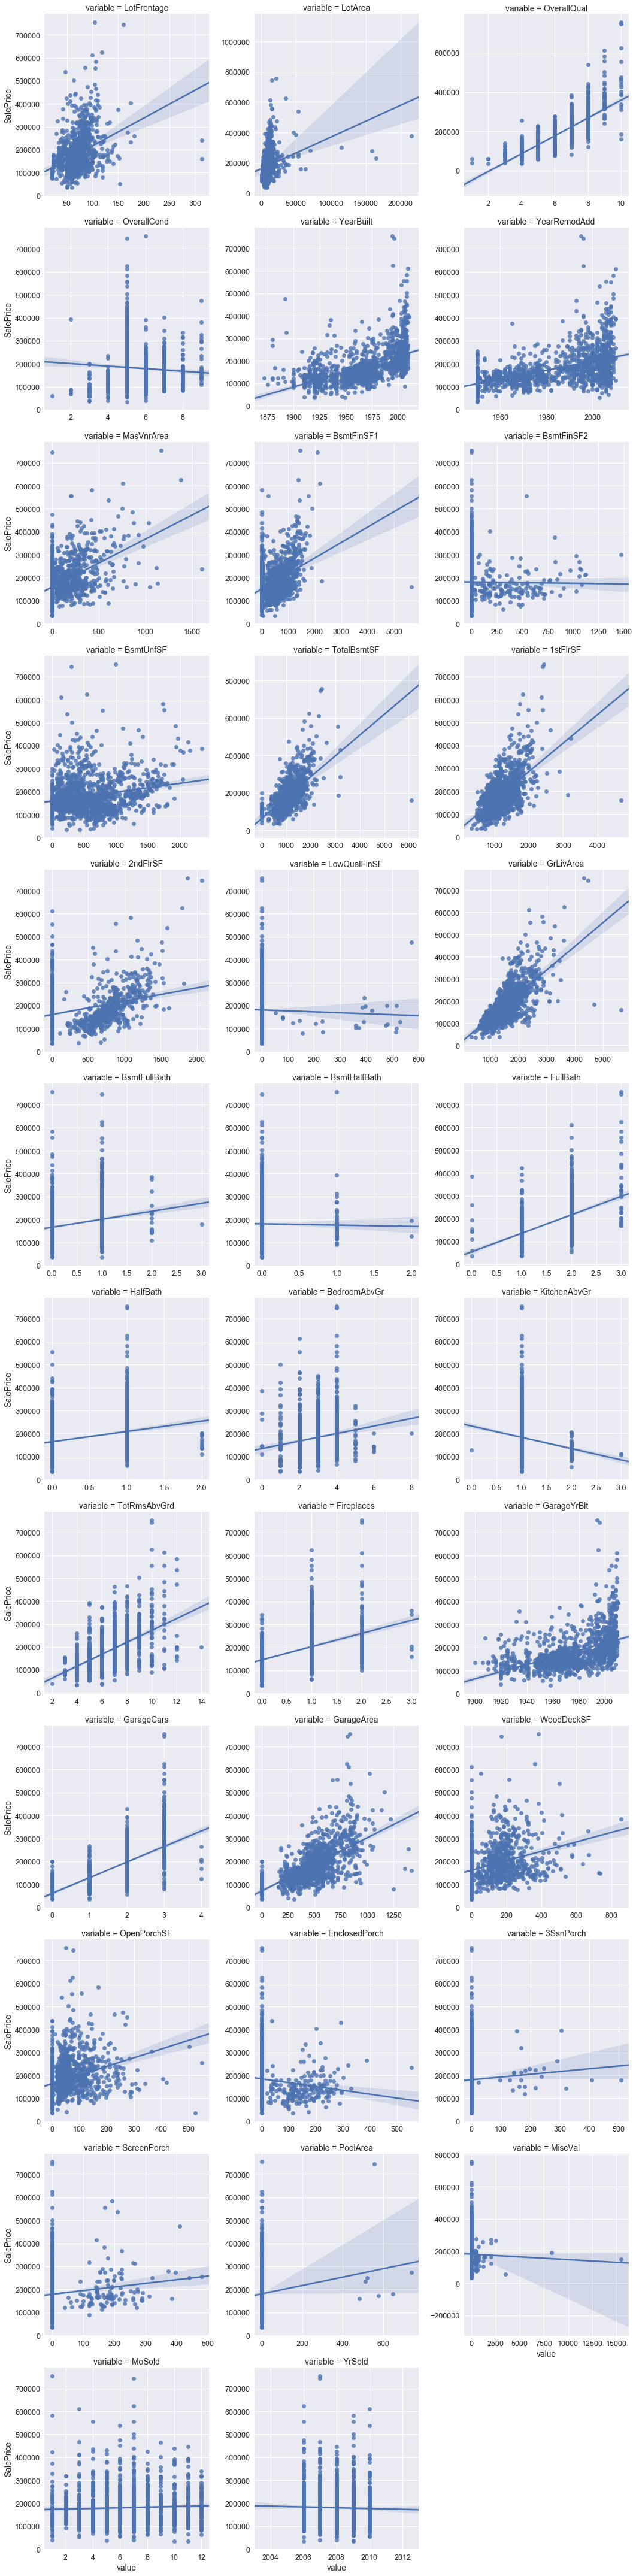

In [39]:
plt.rcParams['figure.figsize'] = (10, 6)
def jointplot(x,y,**kwargs):
    try:
        sns.regplot(x=x,y=y)
    except Exception:
        print(x.value_counts())
num_trainData = num_trainData.iloc[:,2:-1] #获取除id和SalePrice外的数值类型
f = pd.melt(traindata, id_vars=['SalePrice'],value_vars=num_trainData)
g = sns.FacetGrid(f,col='variable',col_wrap=3,sharex=False,sharey=False,size=5)
g = g.map(jointplot,"value","SalePrice")
plt.show()

### 用corr()计算出各列与'SalePrice'的相关性

可以看到，'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea,' 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd'，排在前十的、关系系数超过0.5的这些columns，与'SalePrice'有较大的相关性，特别是'OverallQual'和'GrLivArea'。

## 处理非数字特征

In [9]:
# exclude-排除，这里选择所有的非数字特征
categorical_feats = traindata.select_dtypes(exclude=[np.number])

In [10]:
categorical = categorical_feats.iloc[:,19:]
categorical.describe()

,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,1423,1423,1422,1423,1422,1460,1460,1460,...,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,6,4,4,4,6,6,6,5,2,...,6,3,5,5,3,3,4,4,9,6
top,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1282,647,649,1311,953,430,1256,1428,741,1365,...,870,605,1311,1326,1340,3,157,49,1267,1198


该count列表示非空观测unique值的计数，同时计数唯一值的数量。top是最常见的值，最高值的频率显示为freq。

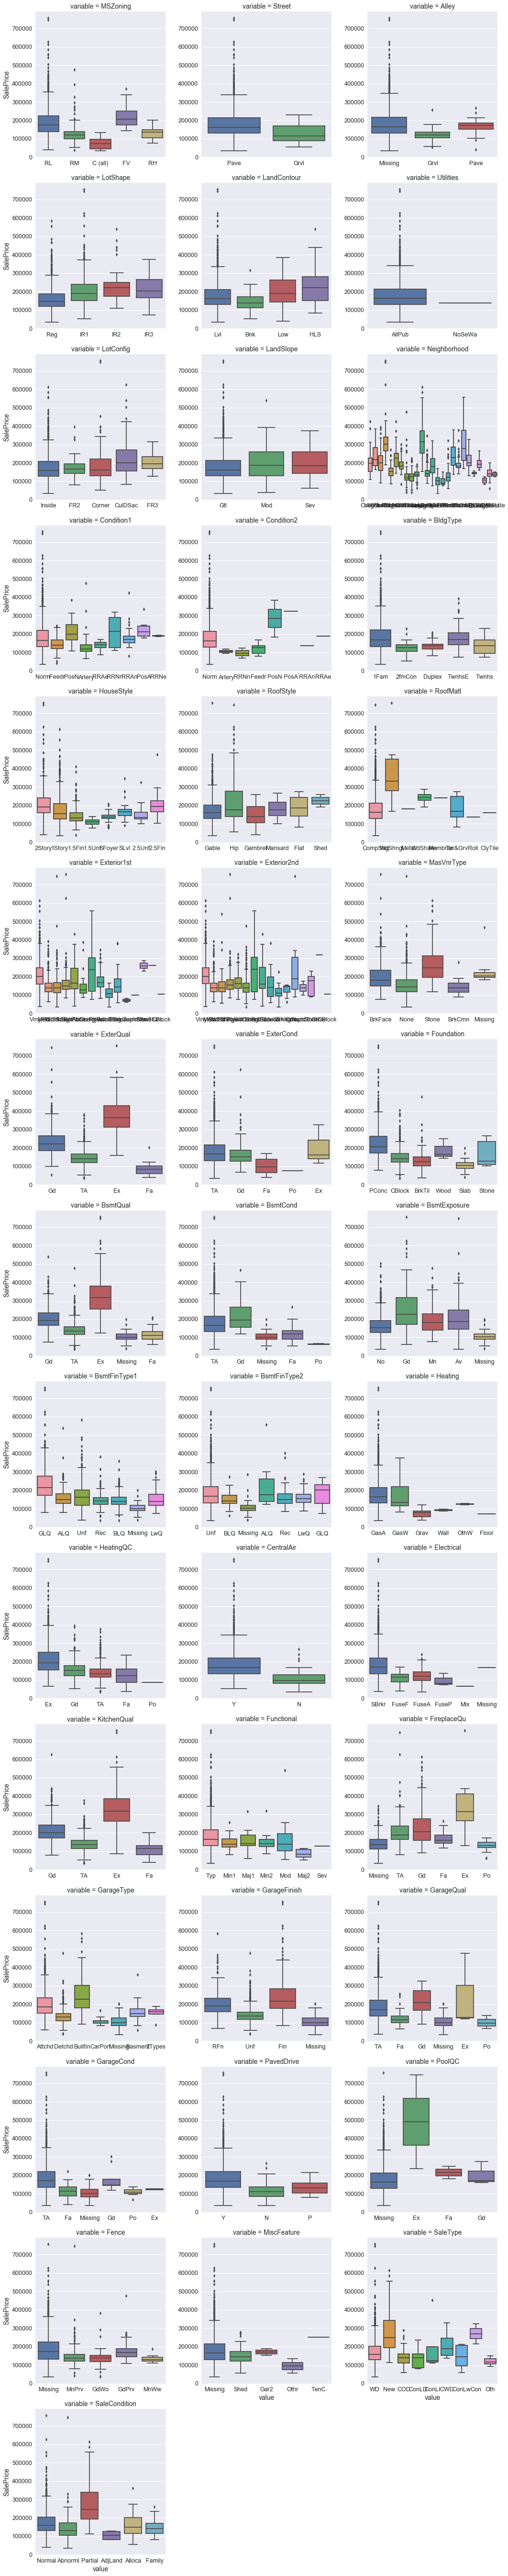

In [40]:
for c in categorical_feats:
    traindata[c] = traindata[c].astype('category')
    if traindata[c].isnull().any():
        traindata[c] = traindata[c].cat.add_categories(["Missing"])
        traindata[c] = traindata[c].fillna("Missing")
def boxplot(x,y,**kwargs):
    sns.boxplot(x=x,y=y)
f = pd.melt(traindata,id_vars=['SalePrice'],value_vars=categorical_feats)
g = sns.FacetGrid(f,col='variable',col_wrap=3,sharex=False,sharey=False,size=5)
g = g.map(boxplot,"value","SalePrice")
plt.show()

可以看到些类别跟房价是有一些线性关系的，之后可尝试将其转为数值来处理。

大体可看出
* 跟房价是有一些线性关系的：LotShape

* 两类的：
Street
Utilities
CentralAir

* 可分为两类的：
LandContour
LandSlope
Condition1
Condition2
BldgType
RoofStyle
ExterCond
BsmtQual
BsmtExposure
BsmtFinType2
Heating
Electrical
Functional
GarageQual
GarageCond
PavedDrive
SaleType
SaleCondition

* 多个的：
MSZoning
LotShape
LotConfig
Neighborhood
HouseStyle
ExterQual
Foundation
BsmtFinType1
HeatingQC
KitchenQual
GarageType
GarageFinish

## 整体变量之间的关系

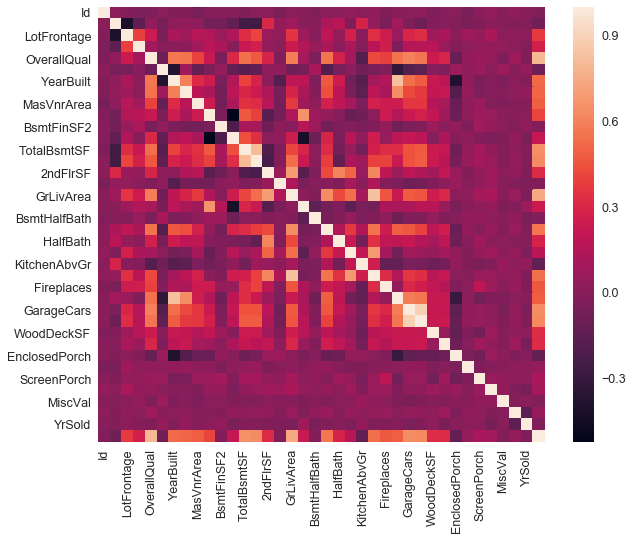

In [30]:
plt.subplots(figsize=(10,8))
corrmat = traindata.corr()
g = sns.heatmap(traindata.corr())
plt.show()

越亮的地方相关性就越高
* 从图中可看出，TotalBmstSF和1stFlrSF相关性就很高，因为地下室的面积一般就跟第一层楼的面积差不多吧
* GarageCars和GarageArea的相关性也很高，因为它们都是用来衡量车库大小的。
* 另外还有TotalRmsAbvGr和GrLivArea，GarageYrBlt和YearBuilt等。说明这些数据出现了多重共线性，几乎包含相同的信息，所以我们可以适当的删除一些变量
* 另外还可以看到和SalePrice相关度比较高的一些变量，比如有OverallQual,GrLivArea,GarageCars等。

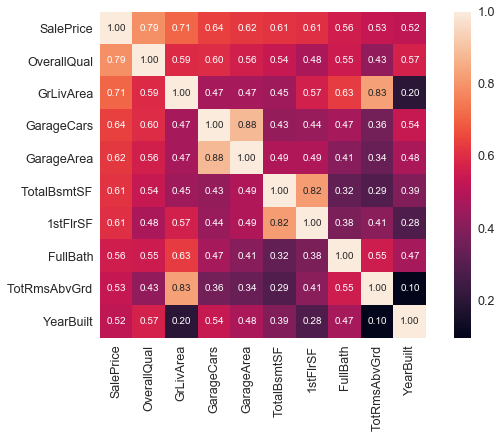

In [13]:
k = 10 #number ofvariables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(traindata[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, 
yticklabels=cols.values, xticklabels=cols.values)
plt.show()

可以看到
* 跟上图我们得到的结论差不多，一些数据出现了多重共线性，可以选择其中一个跟 SalePrice 的相关性更高的变量作为特征就好
* GarageCars 和 GarageArea我们选择GarageCars
* TotalBmstSF和1stFlrSF我们选择TotalBmstSF
* TotalRmsAbvGr和GrLivArea
* GarageYrBlt和YearBuilt

## 除去异常值

In [14]:
# 删除'GrLivArea'最大且和'SalePrice'不成正比的两个'Id'
traindata.drop(traindata[(traindata['GrLivArea']>4000)&(traindata.SalePrice<300000)].index,inplace=True)

## 处理缺失值

In [15]:
features = pd.concat([traindata, testdata],keys=['train','test'])

In [16]:
# 查看每个column缺失值总数和百分比
total = features.isnull().sum().sort_values(ascending=False)
percent = (features.isnull().sum()/features.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(10)

,Total,Percent
SalePrice,1459,0.500171
PoolQC,1456,0.499143
MiscFeature,1408,0.482688
Alley,1352,0.463490
Fence,1169,0.400754
FireplaceQu,730,0.250257
LotFrontage,486,0.166610
GarageYrBlt,159,0.054508
GarageQual,78,0.026740
GarageFinish,78,0.026740


* PoolQC: 泳池质量
* MiscFeature: 其他各种杂项设施
* Alley：胡同，小巷
* Fence: 栅栏质量
* FireplaceQu: 壁炉质量

当超过 15% 的数据都缺失的时候，我们应该删掉相关变量且假设该变量并不存在。
* 例如 PoolQC，MiscFeature，Alley 等等，这些变量都不是很重要，因为他们基本都不是我们买房子时会考虑的因素。
* GarageX 变量群的缺失数据量都相同，由于关于车库的最重要的信息都可以由 GarageCars 表达，并且这些数据只占缺失数据的 5%，我们也会删除上述的 GarageX 变量群。同样的逻辑也适用于 BsmtX 变量群。

对剩下的缺失值
* KitchenQual,Electrical,Exterior1st,Exterior2nd  ，表示房子外墙的材料类型
* BsmtUnfSF，BsmtFinSF1,BsmtFinSF2  是描述地下室的
* TotalBsmtSF   
* GarageCars   

## 准备训练数据

In [17]:
features.head()

1stFlrSF  2ndFlrSF  3SsnPorch    Alley  BedroomAbvGr BldgType  \
train 0       856       854          0  Missing             3     1Fam   
      1      1262         0          0  Missing             3     1Fam   
      2       920       866          0  Missing             3     1Fam   
      3       961       756          0  Missing             3     1Fam   
      4      1145      1053          0  Missing             4     1Fam   

        BsmtCond BsmtExposure  BsmtFinSF1  BsmtFinSF2  ...   SaleType  \
train 0       TA           No       706.0         0.0  ...         WD   
      1       TA           Gd       978.0         0.0  ...         WD   
      2       TA           Mn       486.0         0.0  ...         WD   
      3       Gd           No       216.0         0.0  ...         WD   
      4       TA           Av       655.0         0.0  ...         WD   

        ScreenPorch  Street  TotRmsAbvGrd TotalBsmtSF  Utilities WoodDeckSF  \
train 0           0    Pave             8       856.0     AllPub          0   
      1           0    Pave             6      1262.0     AllPub        298   
      2           0    Pave             6       920.0     AllPub          0   
      3           0    Pave             7       756.0     AllPub          0   
      4           0    Pave             9      1145.0     AllPub        192   

        YearBuilt YearRemodAdd YrSold  
train 0      2003         2003   2008  
      1      1976         1976   2007  
      2      2001         2002   2008  
      3      1915         1970   2006  
      4      2000         2000   2008  

[5 rows x 81 columns]

### 数据转换

* 有些数值特征的分布偏度比较大，可以通过对数变化使其变成正态分布
* 将偏斜度大于0.75的数值列做一个log转换，使之尽量符合正态分布。用`boxcox变换`完成转换操作)

使用one-hot编码将数据转换为布尔列

* 使用`get_dummies()`方法,标准化数据
* 将字符串特征列中的内容分别提出来作为新的特征出现，这样就省去了将字符串内容转化为数值特征内容的步骤了。